In [1]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyrOpt//"
import numpy as np
import matplotlib.pyplot as plt
save_dir = "C://Users//User//Desktop//pcoop_plots//"
import time
import os
import matplotlib.colors as mcolors
from numba import jit
import os
os.environ['OMP_NUM_THREADS'] = '1'  # set the value to 4

In [2]:
def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = ""
    if surf_idx:
        out_str += "2n-trans//"
    else:
        out_str += "2n-cis//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str

surf_labels = ["cis", "trans"]
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "-1.5V", "-1.2V","-0.9V", "-0.6V"]

def gen_dirname(lookat1, lookat2, surf_idx, save_dir):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel
    out_str += lookat1.split(' #')[0]
    out_str += lookat1.split(' #')[1]
    out_str += '-'
    out_str += lookat2.split(' #')[0]
    out_str += lookat2.split(' #')[1]
    out_str += '//'
    return out_str

def lb_idx(Emin, dE, sample):
    a = sample-Emin
    b = a/dE
    c = int(np.floor(b))
    return c, abs(b-c)

def lsstr(atom_label):
    saveable_string = ""
    use = atom_label.split(" #")
    for u in use:
        saveable_string += u
    return saveable_string

@jit(nopython=True)
def get_overlap_matrix(proj, wk, orbs_sample, nk, nj, out):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    out[i, j] += abs(t1_conj * t2) * abs(wk[ik])
    return out

def system_atomwise_pcoop_matrix_all(surf_idx, bias_idx):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    # T_juk, P_uvjk, e_jk = cfunc.prepare_small_funcs(proj, E)
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    pcoops_list = get_overlap_matrix(np.array(proj, dtype=np.complex128), np.array(wk), np.array(orbs_sample, dtype=int), nk, nj, np.zeros([len(orbs_sample), len(orbs_sample)], dtype=np.complex128))
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, mu, orbs_dict.keys()

@jit(nopython=True)
def get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    nrange = 10
    for i in range(nrange):
        act = idx + i - int(np.floor(nrange/2.))
        outij[act] += height*np.exp(-((Erange[act] - ejk)**2)/(4*dE))


@jit(nopython=True)
def get_overlap_matrix_plottable_smear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_smear_helper(ejk, height, Erange, out[i,j], dE)
    return out


#@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    spill = abs(b-idx)
    outij[idx] += height*(1 - spill)
    outij[idx+1] += height*spill

#@jit(nopython=True)
def get_overlap_matrix_plottable_nosmear(proj, E, wk, orbs_sample, nk, nj, out, Erange, dE):
    for i in range(len(orbs_sample)):
        for j in range(len(orbs_sample)):
            for u1 in orbs_sample[i]:
                if u1 > 0:
                    for v1 in orbs_sample[j]:
                        if v1 > 0:
                            for ik in range(nk):
                                for ij in range(nj):
                                    ejk = E[ik][ij]
                                    t1 = proj[ik][ij][u1]
                                    t2 = proj[ik][ij][v1]
                                    t1_conj = t1.real - t1.imag * 1j
                                    height = t1_conj * t2 * wk[ik]
                                    get_overlap_matrix_plottable_nosmear_helper(ejk, height, Erange, out[i,j], dE)
    return out

def system_atomwise_pcoop_matrix_all_plottable(surf_idx, bias_idx, dosmear=True):
    proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
        app_dir(surf_idx, bias_idx) + "bandProjections",
        app_dir(surf_idx, bias_idx) + "Gvectors",
        app_dir(surf_idx, bias_idx) + "eigenvals")
    Emin = np.min(E)
    Emax = np.max(E)
    dE = 0.01
    Emax, Emin = cfunc.adjust_Ebounds(Emin, Emax, dE)
    Erange = np.arange(Emin, Emax, dE)
    orbs_dict = cfunc.orbs_idx_dict(app_dir(surf_idx, bias_idx) + "out", nOrbsPerAtom)
    S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    nk, nj = np.shape(E)
    orbital_labels = []
    maxint = max(orbs_dict["Pt #1"]) + 2
    for i in range(maxint):
        orbital_labels.append("n/a")
    pt_orbs = ["6s", "6px", "6py", "6pz", "7px", "7py", "7pz", "5dxy", "5dyz", "5dxz", "5dx2y2", "5dz2"]
    ticker = 0
    for atom in orbs_dict.keys():
        if ("C " in atom) or ("N " in atom):
            orbital_labels[ticker] = "2s"
            orbital_labels[ticker + 1] = "2px"
            orbital_labels[ticker + 2] = "2py"
            orbital_labels[ticker + 3] = "2pz"
            ticker += 4
        else:
            for orb in pt_orbs:
                orbital_labels[ticker] = orb
                ticker += 1
    orbs_sample = np.ones([len(orbs_dict.keys()), 12]) * (-1)
    for i, keyi in enumerate(orbs_dict.keys()):
        for j, idxj in enumerate(orbs_dict[keyi]):
            orbs_sample[i][j] = orbs_dict[keyi][j]
    ## JIT THIS UP
    ###############
    if dosmear:
        pcoops_list = get_overlap_matrix_plottable_smear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    else:
        pcoops_list = get_overlap_matrix_plottable_nosmear(np.array(proj, dtype=np.complex128),
                                               E,
                                               np.array(wk),
                                               np.array(orbs_sample, dtype=int),
                                               nk, nj,
                                               np.zeros([len(orbs_sample), len(orbs_sample), len(Erange)], dtype=np.complex128),
                                               Erange, dE)
    ###############
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return pcoops_list, Erange, mu, orbs_dict.keys()

datum = []
times = []
bidrange = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for sidx in [0,1]:
    datum.append([])
    for bidx in bidrange:
        start = time.time()
        datum[-1].append(system_atomwise_pcoop_matrix_all_plottable(sidx, bidx))
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(str(sidx*len(bidrange) + bidx + 5) + "/18: " + str(elapsed) + " seconds.")
        print('avg: ' + str(np.average(times)))

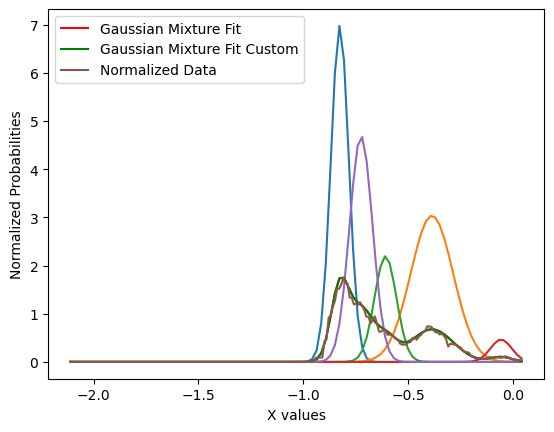

[0.00113897]


In [296]:
from sklearn.mixture import GaussianMixture
# import warnings
# warnings.filterwarnings("ignore")
def smooth(y, loops = 1, _loop = 0):
    nsamples = len(y)
    if _loop < loops:
        out = np.zeros(nsamples)
        for i in range(1, nsamples-1):
            out[i] += np.average(y[i-1:i+2])
        out[0] += y[0]
        out[-1] += y[-1]
        return smooth(out, loops = loops, _loop = _loop + 1)
    else:
        return y

def gaussfit(xx, y, n_gaussians, max_iter = 100, n_init = 1, tol  = 1e-3):
    y_normalized = y / y.sum()
    x_sample = np.repeat(xx, (y_normalized * 5000).astype(int))
    X = x_sample[:, np.newaxis]
    gmm = GaussianMixture(n_components=n_gaussians, max_iter=max_iter, tol=tol, n_init = n_init)
    gmm.fit(X)
    return gmm

def get_each_gaus(gmm, xrange):
    ngaus = len(gmm.weights_)
    yys = []
    for i in range(ngaus):
        prefac = gmm.weights_[i]/np.sqrt(gmm.covariances_[i])
        yys.append(prefac*np.exp(-(1/2)*
                                 (
                                         (xrange - gmm.means_[i])/(np.sqrt(gmm.covariances_[i]))
                                 )**2)
                   )
    return yys

def overlap(dist1, dist2, weight1, weight2):
    nsamples = len(dist1)
    ovrlp = 0
    for i in range(nsamples):
        ovrlp += dist1[i] * dist2[i]
    return ovrlp / (weight1 + weight2)

def find_closest_index(xval, xrange, _best_dist = 1000, _idx = None):
    for i, x in range(len(xrange)):
        dist = abs(xval - x)
        if dist < _best_dist:
            _best_dist = dist
            _idx = i
    return _idx

def find_strattle_indices(xval, xrange):
    best1, idx1 = 1000, None
    best2, idx2 = 1000, None
    for i, x in enumerate(xrange):
        dist = xval - x
        if dist <= 0:
            if abs(dist) < best1:
                best1 = abs(dist)
                idx1 = i
        else:
            if abs(dist) < best2:
                best2 = abs(dist)
                idx2 = i
    if idx1 is None:
        idx1 = idx2
    if idx2 is None:
        idx2 = idx1
    return min(idx1, idx2), max(idx1,idx2)

def recast_axis(xrange, xrange_old, y_old):
    ynew = np.zeros(len(xrange))
    interp = len(xrange) < len(xrange_old)
    if interp:
        for i in range(len(xrange)):
            ynew[i] += y_old[find_closest_index(xrange[i], xrange_old)]
    else:
        for i in range(len(xrange)):
            i1, i2 = find_strattle_indices(xrange[i], xrange_old)
            ynew[i] += (y_old[i1] + y_old[i2])/2.
    return ynew

def get_distribution(yys, yy_sum_in):
    for yy in yys:
        yy_sum_in += yy
    return yy_sum_in

def get_score(xx, y, gmm):
    _yy_in=np.zeros((100,1))
    xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
    yys = get_each_gaus(gmm, xx_range)
    yy = get_distribution(yys, _yy_in)
    y = recast_axis(xx, xx_range, y)
    shift = np.max(y)/np.max(yy)
    yy *= shift
    off = 0
    for i in range(100):
        off += abs(yy[i] - y[i])
    return off/100

look = datum[0][0]
xx = look[1]
y = np.real(smooth(look[0][2][2], loops = 0))
gmm = gaussfit(xx, y, 5, tol=1e-5, n_init=10)
ngaus = len(gmm.means_)
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))
yy_og = np.exp(-((xx_range - gmm.means_[0])/(np.sqrt(2*gmm.covariances_[0])))**2)
shift1 = np.max(y)/np.max(yy_gmm)
plt.plot(xx_range, yy_gmm*shift1, 'r-', label='Gaussian Mixture Fit')
yy_sum = np.zeros(np.shape(xx_range))
for yy in get_each_gaus(gmm, xx_range):
    plt.plot(xx_range, yy)
    yy_sum += yy
shift2 = np.max(y)/np.max(yy_sum)
plt.plot(xx_range, yy_sum*shift2, 'g-', label='Gaussian Mixture Fit Custom')
plt.plot(look[1], y, label='Normalized Data')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()
print(get_score(xx,y, gmm))

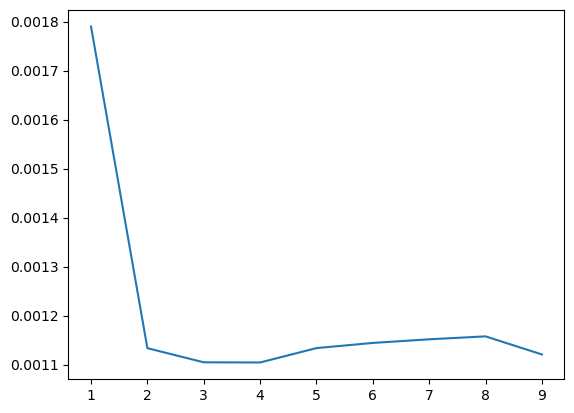

In [297]:
ngaus_list = np.arange(1, 10, dtype=int)
scores = []
look = datum[0][0]
xx = look[1]
y = np.real(smooth(look[0][2][2], loops = 0))
for n in ngaus_list:
    gmm = gaussfit(xx, y, n, tol=1e-5, n_init=10)
    scores.append(get_score(xx,y, gmm))
plt.plot(ngaus_list, scores)

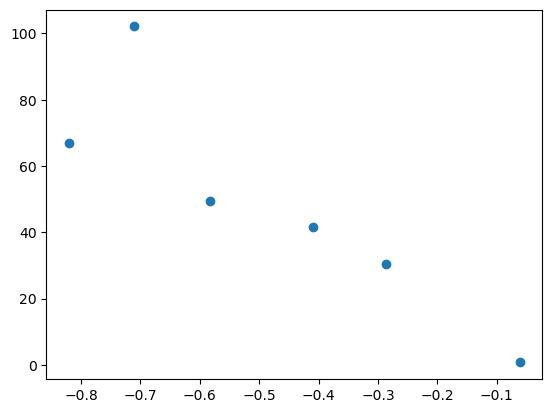

In [253]:
yys = get_each_gaus(gmm, xx_range)
means = gmm.means_
weights = gmm.weights_
overlap_list = []
covar_list = []
for i in range(len(yys)):
    overlaps = 0
    for j in range(len(yys)):
        if i != j:
            overlaps += overlap(yys[i], yys[j], weights[i], weights[j])
    overlap_list.append(overlaps)
    covar_list.append(gmm.covariances_[i])
plt.scatter(means, overlap_list)
#plt.xlim(np.min(xx_range), np.max(xx_range))

In [149]:
np.sum(gmm.weights_)

0.9999999999999999

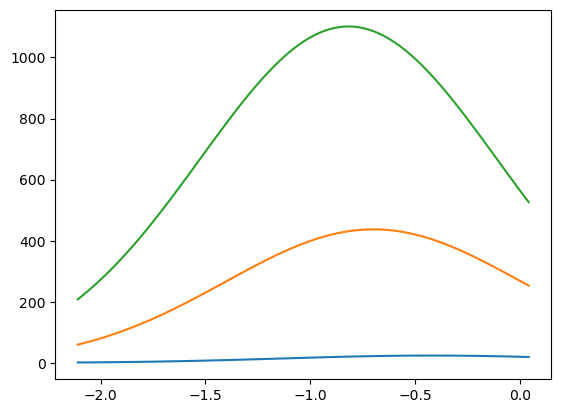

In [122]:
for i in range(len(gmm.means_)):
    plt.plot(xx_range, shift*(1/np.sqrt(2*np.pi*gmm.covariances_[i]))*np.exp(-(xx_range - gmm.means_[i])**2)/(2*gmm.covariances_[i]))

In [124]:
gmm.get_params(True)

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 3,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 1e-05,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [123]:
gmm.covariance_type

'full'

In [102]:
gmm.weights_

array([0.33593303, 0.42332132, 0.24074565])

In [103]:
gmm.means_

array([[-0.81819198],
       [-0.42219133],
       [-0.69855109]])

In [104]:
gmm.covariances_

array([[[0.00212559]],

       [[0.02721018]],

       [[0.00393531]]])

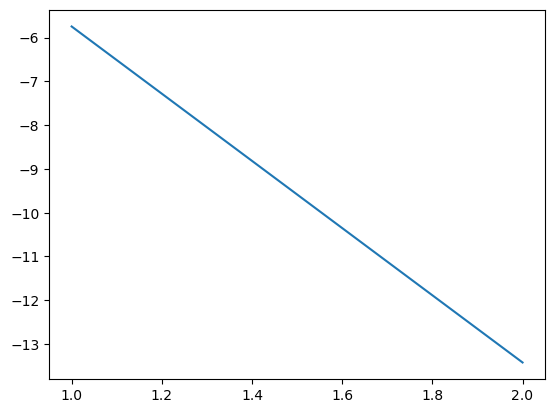

In [68]:
# test convergence
look = datum[0][0]
xx = look[1]
y = np.real(look[0][2][2])
ngaus = np.arange(1, 3, dtype=int)
scores = np.zeros(np.shape(ngaus))
for i, n in enumerate(ngaus):
    gmm, score = gen_gaussfit(xx, y, n)
    scores[i] += score
plt.plot(ngaus, scores)

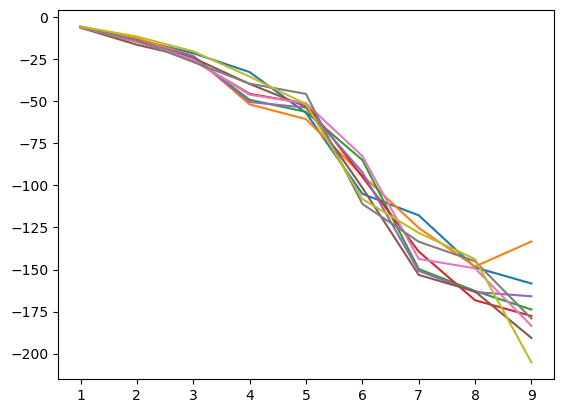

In [72]:
looks = datum[0]
ngaus_list = []
scores_list = []
for look in looks:
    xx = look[1]
    y = np.real(look[0][2][2])
    ngaus = np.arange(1, 10, dtype=int)
    scores = np.zeros(np.shape(ngaus))
    for i, n in enumerate(ngaus):
        gmm, score = gen_gaussfit(xx, y, n, pool=5)
        scores[i] += score
    ngaus_list.append(ngaus)
    scores_list.append(scores)
for i in range(len(looks)):
    plt.plot(ngaus_list[i], scores_list[i])

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

0 False


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

1 False


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

2 False
3 True
4 True
5 True
6 True
7 True
8 True
9 True


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

0 True


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

1 True


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

2 True


C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  war

3 True
4 True
5 True
6 True
7 True
8 True
9 True
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True


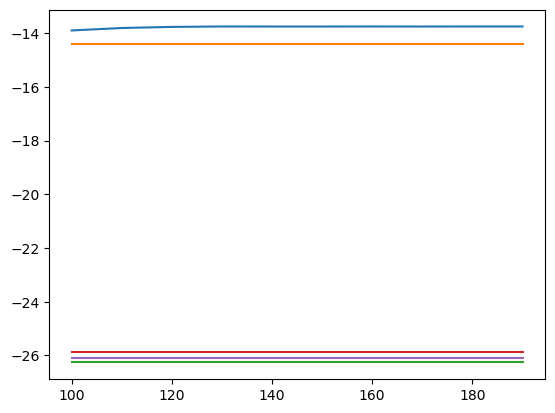

In [82]:
looks = datum[0][:5]
niter_list = []
scores_list = []
ngaus = 3
for look in looks:
    xx = look[1]
    y = np.real(look[0][2][2])
    niters = np.arange(100, 200, 10, dtype=int)
    scores = np.zeros(np.shape(niters))
    for i, ite in enumerate(niters):
        gmm, score = gen_gaussfit(xx, y, ngaus, max_iter=ite, pool=50, tol=1e-5)
        print(str(i) + " " + str(gmm.converged_))
        scores[i] += score
    niter_list.append(niters)
    scores_list.append(scores)
for i in range(len(looks)):
    plt.plot(niter_list[i], scores_list[i])

In [46]:
looks = datum[0]
ngaus_list = []
weights_list = []
ngaus = 10
for look in looks:
    xx = look[1]
    y = np.real(look[0][2][2])
    weights = []
    gmm, score = gen_gaussfit(xx, y, ngaus)
    weights.append(gmm.weights_)
    weights_list.append(weights)
# for i in range(len(looks)):
#     plt.plot(ngaus_list[i], scores_list[i])

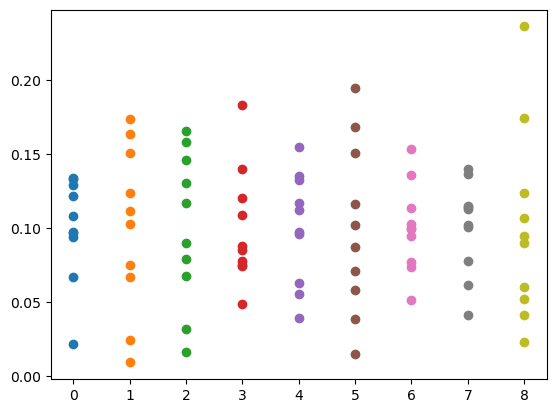

In [47]:
for i, look in enumerate(looks):
    plt.scatter([i]*ngaus, weights_list[i][0])

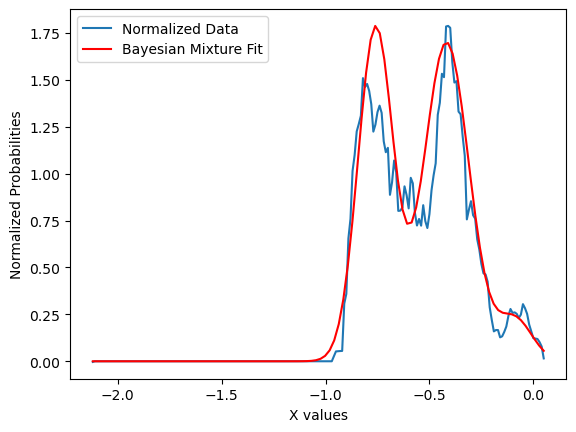

-26.552828263691413


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
# Input data
look = datum[0][3]
xx = look[1]
y = np.real(look[0][2][2])

def gen_bayesefit(xx, y, n_gaussians):
    # Normalize y values to represent probabilities
    y_normalized = y / y.sum()
    # Create dataset with x values repeated according to their probabilities
    x_sample = np.repeat(xx, (y_normalized * 3000).astype(int))
    # Prepare the data for fitting
    X = x_sample[:, np.newaxis]
    # Create a GaussianMixture model
    gmm = BayesianGaussianMixture(n_components=n_gaussians, max_iter=200)
    # Fit the model to the data
    gmm.fit(X)
    score = gmm.score(xx.reshape(-1, 1), y)
    return gmm, score

gmm, score = gen_bayesefit(xx, y, 3)
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.score_samples(xx_range))
shift = np.max(y)/np.max(yy_gmm)
plt.plot(look[1], y, label='Normalized Data')
plt.plot(xx_range, yy_gmm * shift, 'r-', label='Bayesian Mixture Fit')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()
print(score)

In [114]:
# figure out how to plot individual peaks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
# Input data
look = datum[0][3]
xx = look[1]
y = np.real(look[0][2][2])

def gen_bayesefit(xx, y, n_gaussians):
    # Normalize y values to represent probabilities
    y_normalized = y / y.sum()
    # Create dataset with x values repeated according to their probabilities
    x_sample = np.repeat(xx, (y_normalized * 3000).astype(int))
    # Prepare the data for fitting
    X = x_sample[:, np.newaxis]
    # Create a GaussianMixture model
    gmm = BayesianGaussianMixture(n_components=n_gaussians, max_iter=200)
    # Fit the model to the data
    gmm.fit(X)
    score = gmm.score(xx.reshape(-1, 1), y)
    return gmm, score

gmm, score = gen_bayesefit(xx, y, 3)
xx_range = np.linspace(xx.min(), xx.max(), 100)[:, np.newaxis]
yy_gmm = np.exp(gmm.sample(1))
shift = np.max(y)/np.max(yy_gmm)
plt.plot(look[1], y, label='Normalized Data')
plt.plot(xx_range, yy_gmm * shift, 'r-', label='Bayesian Mixture Fit')
plt.legend()
plt.xlabel('X values')
plt.ylabel('Normalized Probabilities')
plt.show()
print(score)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [111]:
print(gmm.weights_)
print(gmm.means_)
print(gmm.covariances_)
print(gmm.degrees_of_freedom_)

[0.42318588 0.52299012 0.053824  ]
[[-0.75927709]
 [-0.41802202]
 [-0.09059723]]
[[[0.00715775]]

 [[0.01193148]]

 [[0.00703669]]]
[1249.24567295 1544.77453814  159.97978891]
